# Cours PCD – Labo 4 : ACP sur des images


In [80]:
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import ttest_rel

from sklearn import datasets
from sklearn.model_selection import StratifiedKFold, KFold, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.decomposition import PCA

## 1) Description du jeu de données « Olivetti Faces »

Chargement du jeu de données et affichage de sa description intégrée:

In [2]:
olivetti = datasets.fetch_olivetti_faces()
print(olivetti["DESCR"])

.. _olivetti_faces_dataset:

The Olivetti faces dataset
--------------------------

`This dataset contains a set of face images`_ taken between April 1992 and 
April 1994 at AT&T Laboratories Cambridge. The
:func:`sklearn.datasets.fetch_olivetti_faces` function is the data
fetching / caching function that downloads the data
archive from AT&T.

.. _This dataset contains a set of face images: https://cam-orl.co.uk/facedatabase.html

As described on the original website:

    There are ten different images of each of 40 distinct subjects. For some
    subjects, the images were taken at different times, varying the lighting,
    facial expressions (open / closed eyes, smiling / not smiling) and facial
    details (glasses / no glasses). All the images were taken against a dark
    homogeneous background with the subjects in an upright, frontal position 
    (with tolerance for some side movement).

**Data Set Characteristics:**

    =================   =====================
    Classes    

In [3]:
print(np.shape(olivetti["data"]))
print(np.shape(olivetti["images"]))
print(np.shape(olivetti["target"]))

(400, 4096)
(400, 64, 64)
(400,)


On apprend que le jeu de données de 400 images contient 3 parties:

* `data` qui contient les données des images (valeurs des pixels en N&B de 0 à 1) avec 4096 dimensions (pixels) pour chaque image.
* `images` qui contient les données des images sous forme de matrices 64x64.
* `target` qui contient les 40 classes (personnes) du jeu de données, ce qui correspond à 10 par classe.

### b) Nombre de personnes représentées

Il y a 40 personnes représentées avec 10 photos par personne.

### c) Information sur les images

Les images ont une taille de 64 par 64, soit 4096 pixels.

Les images sont encodées en noirs et blancs, avec 256 niveaux de gris (8 bits). Ces valeurs sont actuellement chargées en tant que _float_ compris dans [0, 1], au lieu d'un nombre entier compris dans [0, 255].

In [4]:
len(np.unique(olivetti["data"], axis=0))

400

On constate qu'il n'y a pas d'images dupliquées.

### d) Affichage d'un exemple d'image

In [5]:
def img_plot(img_data):
    fig=plt.figure()
    fig.add_subplot(xticks=[], yticks=[])
    ax = plt.imshow(img_data,cmap=plt.cm.bone)

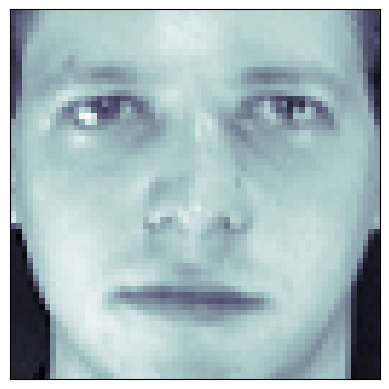

In [6]:
img_plot(olivetti["images"][0])

## 2) Préparation des jeux de données

In [7]:
x_train, x_test, y_train, y_test = train_test_split(olivetti["data"], olivetti["target"], stratify=olivetti["target"], train_size=0.8, random_state=0)

In [8]:
print(f"x_train:\t{np.shape(x_train)}")
print(f"y_train:\t{np.shape(y_train)}")
print(f"x_test :\t{np.shape(x_test)}")
print(f"y_test :\t{np.shape(y_test)}")

x_train:	(320, 4096)
y_train:	(320,)
x_test :	(80, 4096)
y_test :	(80,)


On constate que les dimensions correspondent au ratio de 80% pour l'entraînement et 20% pour le test.

## 3) Expérience de classification

In [9]:
def accuracy_with_clf(clf, x_train, y_train, x_test, y_test):
    """Retourne l'accuracy de la classification de `classifier` sur les données `x` et `y`"""
    clf.fit(x_train, y_train)
    pred = clf.predict(x_test)
    
    return accuracy_score(pred, y_test)

In [10]:
classifiers = {"KNN": KNeighborsClassifier(), "Logistic regression": LogisticRegression(), "SVM": SVC(C=5.0, gamma=0.01)}

for name, clf in classifiers.items():    
    accuracy = accuracy_with_clf(clf, x_train, y_train, x_test, y_test)
    print(f"{name} classification accuracy : {accuracy:.1%}")

KNN classification accuracy : 87.5%
Logistic regression classification accuracy : 93.8%
SVM classification accuracy : 93.8%


C:\Users\hugo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


On constate que les classifieurs SVM et régression logistique possède les deux la meilleure valeur d'_accuracy_ avec **93.8%**

## 4) Application de la méthode ACP

In [11]:
pca = PCA(n_components=150, whiten=True)
pca.fit(x_train)

PCA(n_components=150, whiten=True)

### Affichage d'une sélection d'_eigenfaces_

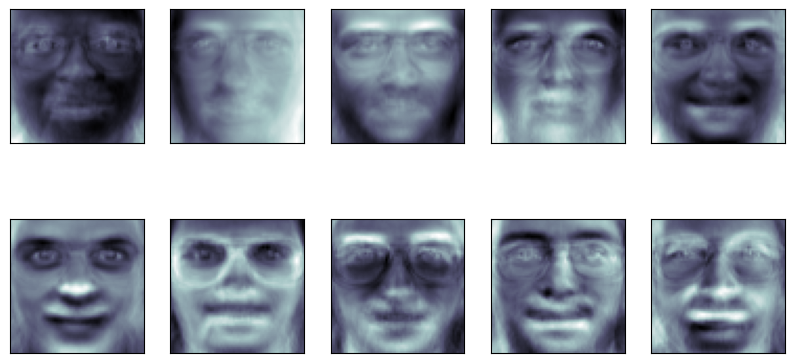

In [12]:
fig = plt.figure(figsize=(10, 5))
for i in range(10):
    ax = fig.add_subplot(2, 5, i + 1, xticks=[], yticks=[])
    ax.imshow(pca.components_[i].reshape(olivetti.images[0].shape), cmap=plt.cm.bone)

### Application aux données d'entraînement et de test

In [13]:
def pca_transform(x_train, x_test, n_components=150):
    """Retourne la transformation avec méthode d'ACP de données d'entraînement et de test"""
    pca = PCA(n_components=n_components, whiten=True)
    pca.fit(x_train)
    
    return pca.transform(x_train), pca.transform(x_test)

In [14]:
x_train_pca, x_test_pca = pca_transform(x_train, x_test)

In [15]:
print(x_train_pca.shape)

(320, 150)


In [16]:
print(x_test_pca.shape)

(80, 150)


On constate la nouvelle taille de 150 dimensions pour chaque image.

Selon la [documentation PCA de _Scikit-learn_](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html), les données sont centrées lors de la transformation; il n'est donc pas nécéssaire des les centrer manuellement en amont.

## 5) Expérience de classification avec les données transformées

In [17]:
for name, clf in classifiers.items():
    accuracy = accuracy_with_clf(clf, x_train_pca, y_train, x_test_pca, y_test)
    print(f"PCA {name} classification accuracy : {accuracy:.1%}")    

PCA KNN classification accuracy : 65.0%
PCA Logistic regression classification accuracy : 93.8%
PCA SVM classification accuracy : 92.5%


On constate que l'accuracy de KNN est plus mauvaise avec l'ACP de **plus de 25 points**.

L'accuracy avec régression logistique est identique avec l'ACP.

L'accuracy avec SVM est très légèrement plus mauvaise de 1 points de pourcentage.

## 6) Recherche du nombre optimal de composantes principales  

In [18]:
def pca_report(x_train, y_train, x_test, y_test, classifiers, n_components_range, verbose=False):
    """
    Retourne les résultats d'accuracy issus d'essais du nombre de composantes principales pour la méthode ACP
    et de l'application de méthodes de classification.
    """
    results = pd.DataFrame(columns=["clf", "n_components", "accuracy"])
    for (name, clf), n_components in itertools.product(classifiers.items(), n_components_range):
        x_train_pca, x_test_pca = pca_transform(x_train, x_test, n_components)

        accuracy = accuracy_with_clf(clf, x_train_pca, y_train, x_test_pca, y_test)
        result = pd.DataFrame([{
            "clf": name,
            "n_components": n_components,
            "accuracy": accuracy
        }])
        
        if verbose:
            print(f"{name} {n_components} : {accuracy}")
            
        results = pd.concat([results, result])
    return results.reset_index(drop=True)

In [19]:
# Valeurs de 1 puis 10, 20, 30.. jusqu'à 320 c-à-d la taille des données d'entraînement,
# qui correspond à la taille limite prise en charge par la méthode d'ACP ici (min(n_samples, n_features)=320).
n_components_range = [1] + list(range(10, 321, 10))
results = pca_report(x_train, y_train, x_test, y_test, classifiers, n_components_range)

### Meilleur accuracy par classifieur

In [20]:
results.loc[results.groupby("clf")["accuracy"].idxmax()]

,clf,n_components,accuracy
2,KNN,20,0.8875
38,Logistic regression,50,0.9625
68,SVM,20,0.9625


Pour KNN, la meilleure accuracy de **0.8875** et atteinte avec **20** composantes.

Pour la Régression logistique, la meilleure accuracy de **0.9750** est atteinte avec **50** composantes.

Pour SVM, la meilleure accuracy de **0.9625** est atteinte avec **20** composantes. 

## 7) Affichage des erreurs du meilleur système

En utilisant le classifieur de Régression logistique et 50 composantes pour l'ACP:

In [21]:
x_train_pca, x_test_pca = pca_transform(x_train, x_test, n_components=50)

In [22]:
clf = LogisticRegression()
clf.fit(x_train_pca, y_train)
pred = clf.predict(x_test_pca)

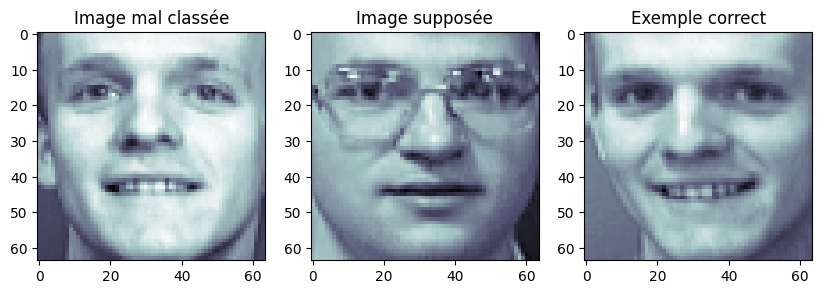

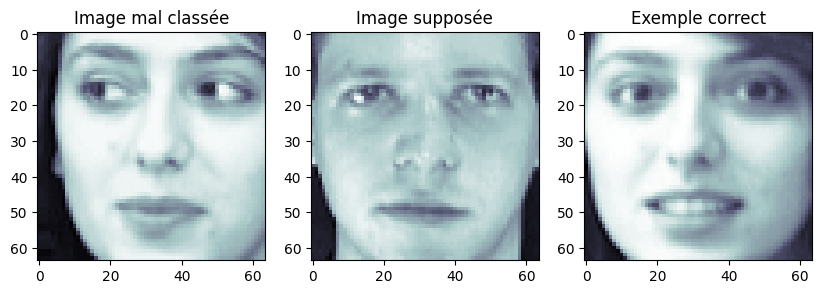

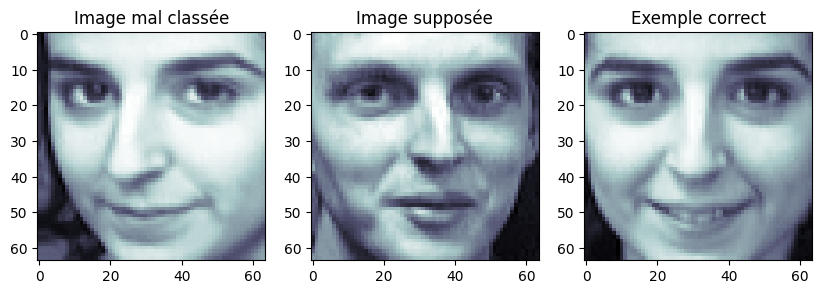

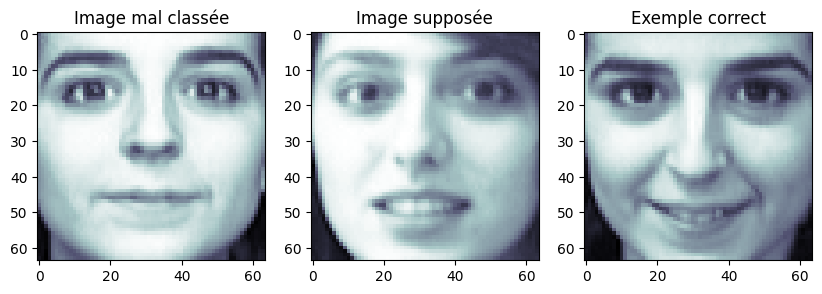

In [105]:
wrong_preds = (np.where(pred != y_test)[0])[:5]
for i in wrong_preds:
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 10))
    
    ax1.imshow(x_test[i].reshape(64, 64), cmap=plt.cm.bone)
    ax1.set_title("Image mal classée")

    ax2.imshow(olivetti.images[10 * pred[i]], cmap=plt.cm.bone)
    ax2.set_title("Image supposée")

    ax3.imshow(olivetti.images[10 * y_test[i]], cmap=plt.cm.bone)
    ax3.set_title("Exemple correct")

    plt.show()

## 8) Validation croisée

En utilisant le classifieur de Régression logistique et 50 composantes pour l'ACP:

In [78]:
def pred_with_clf(clf, x_train, y_train, x_test):
    """Retourne la prediction d'un classifieur `clf`"""
    clf.fit(x_train, y_train)
    return clf.predict(x_test)

In [95]:
skf = StratifiedKFold(n_splits=5)

x, y = olivetti["data"], olivetti["target"]
scores, scores_pca = list(), list()
for k, (train_indexes, test_indexes) in enumerate(skf.split(x, y)):
    print(f"Fold {k+1}..")
    
    # Train-test split
    x_train, y_train = x[train_indexes], y[train_indexes]
    x_test, y_test = x[test_indexes], y[test_indexes]
    
    x_train_pca, x_test_pca = pca_transform(x_train, x_test, n_components=50)
    
    # On obtient les scores
    accuracy = accuracy_with_clf(LogisticRegression(), x_train, y_train, x_test, y_test)
    accuracy_pca = accuracy_with_clf(LogisticRegression(), x_train_pca, y_train, x_test_pca, y_test)
    
    scores.append(accuracy)
    scores_pca.append(accuracy_pca)

Fold 1..


C:\Users\hugo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 2..


C:\Users\hugo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 3..


C:\Users\hugo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 4..


C:\Users\hugo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fold 5..


C:\Users\hugo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [92]:
print(f"Accuracies:          {scores}")
print(f"Accuracies with PCA: {scores_pca}")
print(ttest_rel(scores, scores_pca))

Accuracies:          [1.0, 0.95, 0.95, 0.975, 0.95]
Accuracies with PCA: [1.0, 0.975, 0.975, 0.95, 0.9375]
TtestResult(statistic=-0.2500000000000013, pvalue=0.8149020114591803, df=4)


On constate que la valeur _p-value_ est bien au delà du seuil de 5% (plus de 80% ici), ce qui ne nous permet pas de rejeter l'hypothèse nulle du test de Student apparié. Il n'y a donc pas de différence significative entre les résultat avec et sans traitement d'ACP.